In [1]:
import os
import numpy as np
import mne
import sklearn
import matplotlib.pyplot as plt

In [2]:
# set the participant number
PNUM = "01"

# important channels
RAW_EOG_CHANNELS = [u'EXG1', u'EXG2', u'EXG3', u'EXG4']
MASTOID_CHANNELS = [u'EXG5', u'EXG6']

In [3]:
data_raw_file = os.path.join('raw_data', 'P' + PNUM + '-raw.fif')
raw = mne.io.read_raw_fif(data_raw_file)

Opening raw data file raw_data/P07-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2520436 =      0.000 ...  4922.727 secs
Ready.


In [4]:
print(raw)
print(raw.info)

# plot eeg data
# raw.plot_psd(fmax=30)
# raw.plot(duration=5, n_channels=30)

<Raw | P07-raw.fif, 69 x 2520437 (4922.7 s), ~77 kB, data not loaded>
<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG, 4 EOG, 1 Stimulus
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.0 Hz
 lowpass: 417.0 Hz
 meas_date: 2015-02-12 10:49:08 UTC
 meas_id: 4 items (dict)
 nchan: 69
 projs: Average EEG reference: off
 sfreq: 512.0 Hz
>


In [5]:
# mastoid channel stuff - according to openmirr repo
if MASTOID_CHANNELS[0] in raw.ch_names:
    mne.io.set_eeg_reference(raw.load_data(), MASTOID_CHANNELS, copy=False) # inplace
    raw.drop_channels(MASTOID_CHANNELS)


In [6]:
# Drop bad channels - in place on raw
for bad_channel in raw.info['bads']:
    raw.drop_channels(bad_channel)
    print("dropped: " + bad_channel)

In [7]:
RAW_COPY = raw.copy()

eeg_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

# bandpass filter - keeping a frequency range between 0.5 (high pass filter) and 30 Hz (low pass filter)
filtered_data = raw.load_data().filter(0.5, 30, picks=eeg_picks)

Reading 0 ... 2520436  =      0.000 ...  4922.727 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 3381 samples (6.604 sec)



In [8]:
data_file = os.path.join('ica_data', 'P' + PNUM + '-ica.fif')
ica = mne.preprocessing.read_ica(data_file)
raw_cleaned = ica.apply(filtered_data, exclude=ica.exclude)

Reading ica_data/P07-ica.fif ...


FileNotFoundError: [Errno 2] No such file or directory: 'ica_data/P07-ica.fif'

In [ ]:
events = mne.find_events(raw_cleaned)
print(events)

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
[[    512       0     121]
 [    520       0    1000]
 [   8141       0     122]
 ...
 [2459915       0    2001]
 [2467882       0     224]
 [2467925       0    2001]]


In [ ]:
mapping = {1000: 'audio_onset', 11 : 'instrumental', 12: 'instrumental', 13: 'instrumental', 14: 'instrumental'}
annot_from_events = mne.annotations_from_events(
    events=events, event_desc=mapping, sfreq=raw_cleaned.info['sfreq'],
    orig_time=raw_cleaned.info['meas_date'])
raw_cleaned.set_annotations(annot_from_events)

<Raw | P01-raw.fif, 66 x 2478166 (4840.2 s), ~1.22 GB, data loaded>

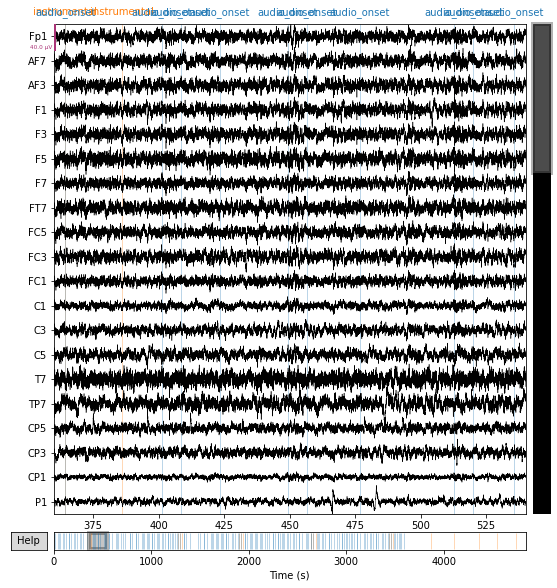

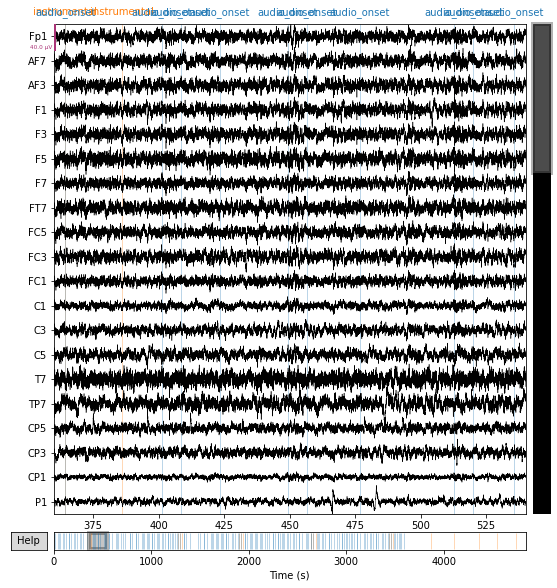

In [ ]:
raw.plot(start=360, duration=180)
